In [2]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

np.random.seed(24) # 42

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwd

In [8]:
def get_data():

    pkl_file = open('train_df.pkl', 'rb')
    df = pickle.load(pkl_file)
    pkl_file.close()
    
    years = np.sort(df['year'].unique())
    
    data = []
    
    for i, j in enumerate(years):
        
        # Data from Prio and UCDP
        df_sub_year = df[df['year']==j]
        X = np.array([df_sub_year['xcoord'], df_sub_year['ycoord']])
        
#         # for spares estimation - better do this out of loop.
#         sub1 = df_sub_year[df_sub_year['best']>0]
#         Xu = np.array([sub1['xcoord'], sub1['ycoord']]).T
        
        # Data from spatial estimation
        file_name = 'spatial_est_{}.pkl'.format(j)
        pkl_file = open(file_name, 'rb')
        estimates = pickle.load(pkl_file)
        pkl_file.close()
        
        year_array = np.zeros(X.shape[1]) + j
        
        data.append(np.dstack([estimates['mu'],estimates['var'],X[0],X[1],year_array])[0,:,:]) # to get rid of a spare dim...

    concat_data = np.concatenate(data)
    
    df_new = pd.DataFrame(concat_data, columns= ['mu','var','xcoord','ycoord','year'])        
    df_full = df.merge(df_new, on = ['xcoord','ycoord','year'], how = 'outer')
    df_full.rename(columns={'mu': 'sce_mu', 'var': 'sce_var'}, inplace=True)
    return(df_full)

df = get_data()

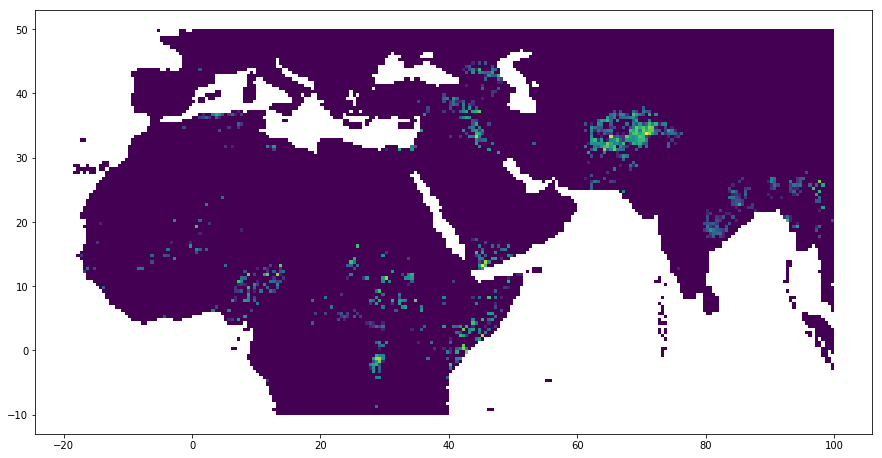

In [18]:
# log(best) test:
df[df['year']==2012].plot(column = 'log_best', figsize=(15, 15))
plt.show()

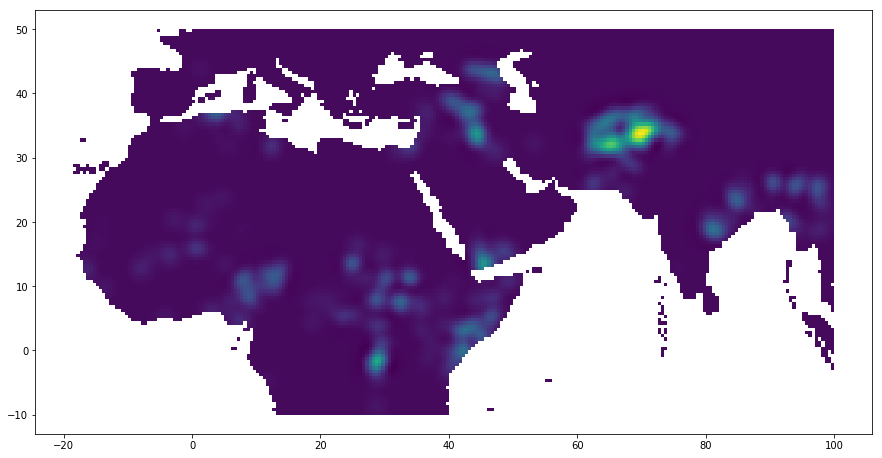

In [13]:
# sce mu test:
df[df['year']==2012].plot(column = 'sce_mu', figsize=(15, 15))
plt.show()

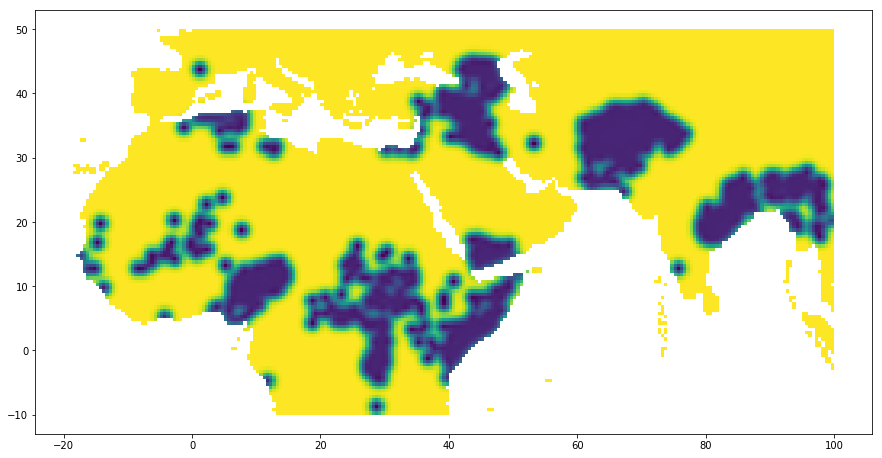

In [11]:
# sce var test
df[df['year']==2012].plot(column = 'sce_var', figsize=(15, 15))
plt.show()

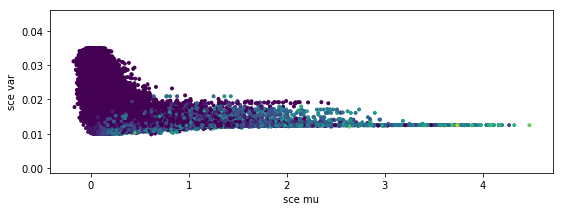

In [52]:
plt.figure(figsize=[9,3])
#plt.plot(df['sce_mu'],df['sce_var'], '.', c = df['log_best'], alpha = 0.3)
plt.scatter(df['sce_mu'], df['sce_var'], s=35, c=df['log_best'], marker='.', cmap='viridis')

plt.xlabel('sce mu')
plt.ylabel('sce var')

plt.show()

**As such it does seem like the sce var could also be quite informative!**
Especially the lower the mu get wich is really good.

# From sce mu to dce mu:

In [25]:
def get_X_new(step_size = 0.25):
    step = step_size
    min_year = df['year'].min()
    max_year = df['year'].max()

    X_new = np.arange(min_year,max_year + step, step)[:,None]
    
    return(X_new)

In [26]:
def get_X_y_index():
    X = np.array(df['year'])[:,None]
    y = np.array(df['sce_mu'])
    index = np.array(df['gid'])
    
    return(X,y,index)

In [27]:
def get_gid_list():
    
    gid_list = []

    for i in df['gid'].unique():
        
        timeline  = df[df['gid'] == i]
        if np.count_nonzero(timeline['log_best']) >= 2:
            gid_list.append(i)
        
    gid_list = np.random.choice(gid_list, 100) # number of samples for hyper parameter estimates.
    
    return(gid_list)

In [30]:
def get_event_timelines():
    df_sub = df[df['gid'].isin(gid_list)].sort_values(['gid','year'])
    
    event_X = np.array(df_sub['year'])[:,None]
    event_y = np.array(df_sub['sce_mu'])
    event_index = np.array(df_sub['gid'])
    
    return(event_X, event_y, event_index)

In [31]:
X_new = get_X_new()
X,y,index = get_X_y_index()
gid_list = get_gid_list()
X1,y1,index1 = get_event_timelines()

# Vizualisation

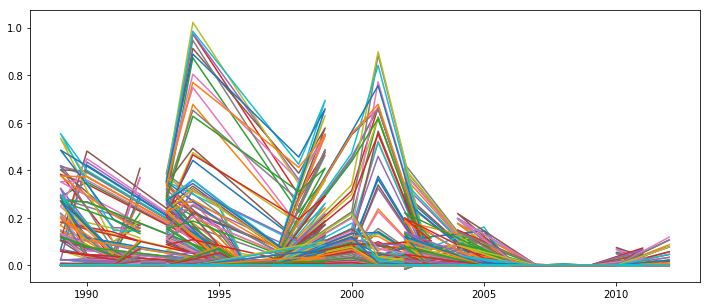

In [32]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()


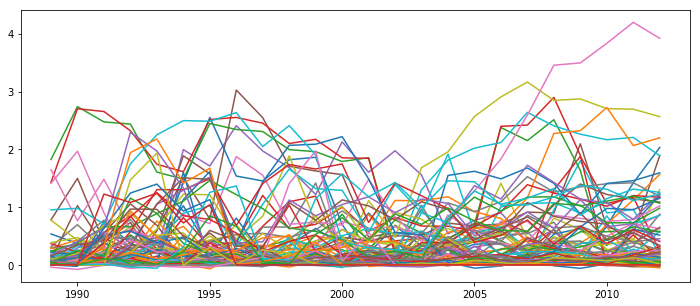

In [33]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation
### Define and illlustrate hyper-priors:

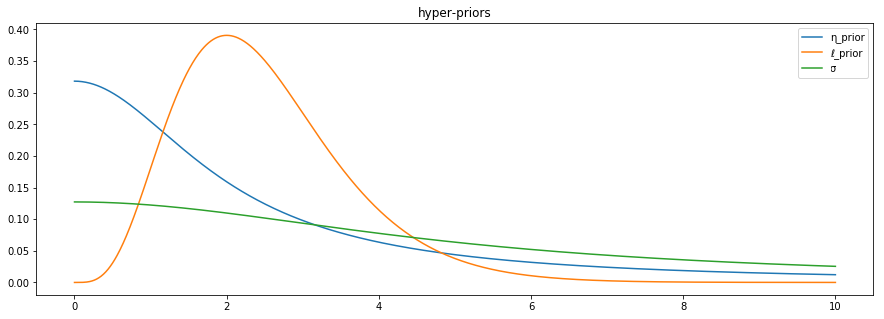

In [34]:
η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

# from sce mu to dce mu model:

In [35]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [36]:
time1 = time.time()

with model:
    trace = pm.sample()
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexin

time total: 51.21229364474615min


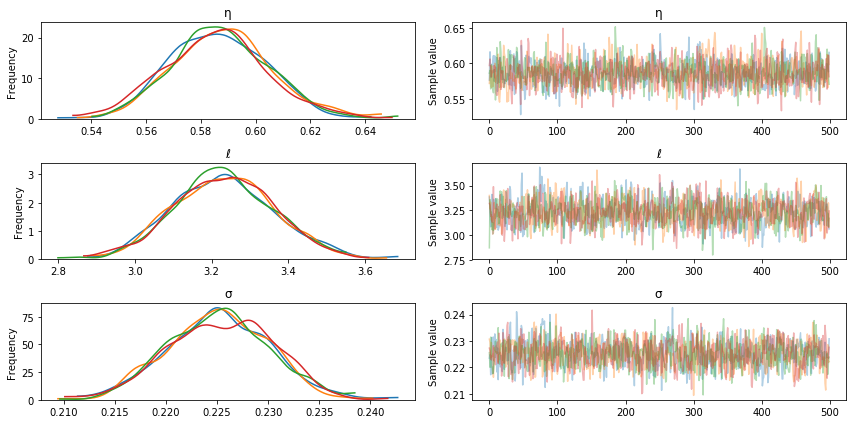

In [37]:
pm.traceplot(trace, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [38]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.230718,0.129914,0.003032,2.991059,3.496759,1294.091935,0.999088
η__0,0.586586,0.018102,0.000488,0.552823,0.622765,1617.494432,1.001777
σ__0,0.225153,0.004943,0.000125,0.215506,0.234296,1334.491718,0.999507


In [40]:
mp = {'ℓ' : np.array([pm.summary(trace)['mean'].iloc[0]]),  
      'η': np.array([pm.summary(trace)['mean'].iloc[1]]), 
      'σ' : np.array([pm.summary(trace)['mean'].iloc[2]])}

mp

{'η': array([0.58658564]), 'σ': array([0.22515332]), 'ℓ': array([3.23071786])}

# Pickle hp dce map and df_sce

In [64]:
file_name = "dce_hp_trace_mu.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace, output)
output.close()

file_name = "dce_hp_mp_mu.pkl"
output = open(file_name, 'wb') 
pickle.dump(mp, output)
output.close()

file_name = "train_df_sce.pkl"
output = open(file_name, 'wb') 
pickle.dump(df, output)
output.close()

# From sce var to dce var:

In [53]:
def get_X_y_index():
    X = np.array(df['year'])[:,None]
    y = np.array(df['sce_var'])
    index = np.array(df['gid'])
    
    return(X,y,index)

def get_event_timelines():
    df_sub = df[df['gid'].isin(gid_list)].sort_values(['gid','year'])
    
    event_X = np.array(df_sub['year'])[:,None]
    event_y = np.array(df_sub['sce_var'])
    event_index = np.array(df_sub['gid'])
    
    return(event_X, event_y, event_index)

X,y,index = get_X_y_index()
X1,y1,index1 = get_event_timelines()

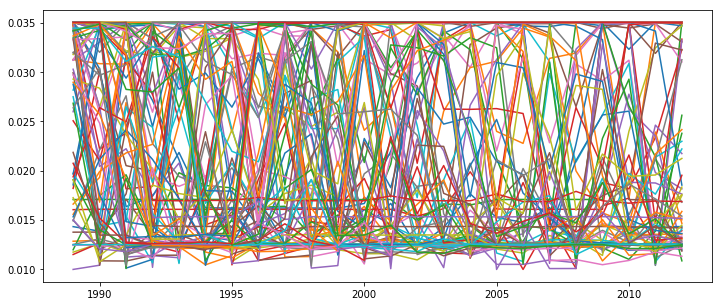

In [54]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# from sce var to dce var model:

In [55]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [56]:
time1 = time.time()

with model:
    trace_var = pm.sample()
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ℓ]
Sampling 4 chains: 100%|██████████| 4000/4000 [56:57<00:00,  1.15draws/s]
The acceptance probability does not match the target. It is 0.8954825208964001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058477702051283, but should be close to 0.8. Try to increase the number of tuning steps.


time total: 66.82505888144175min


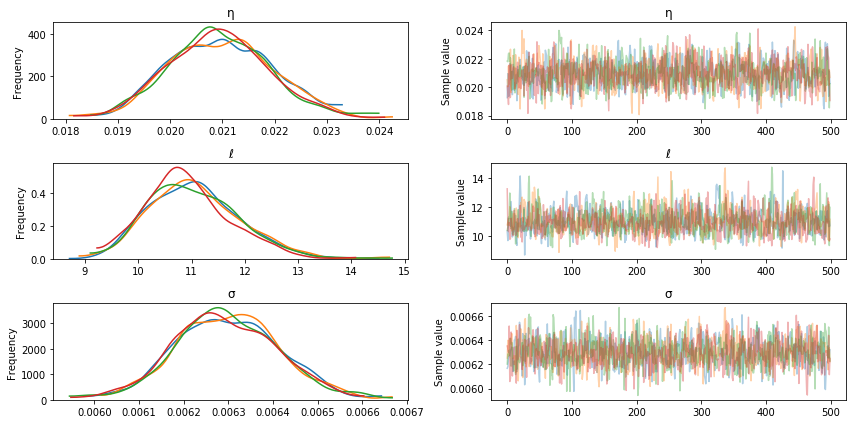

In [57]:
pm.traceplot(trace_var, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [58]:
pm.summary(trace_var)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,11.036239,0.853773,0.023848,9.481495,12.698548,1204.043862,1.002010
η__0,0.020953,0.000979,0.000026,0.019157,0.022928,1493.826661,0.999539
σ__0,0.006296,0.000115,0.000003,0.006077,0.006526,1588.711921,1.000050


In [60]:
mp_var = {'ℓ' : np.array([pm.summary(trace_var)['mean'].iloc[0]]),  
      'η': np.array([pm.summary(trace_var)['mean'].iloc[1]]), 
      'σ' : np.array([pm.summary(trace_var)['mean'].iloc[2]])}

mp_var

{'η': array([0.02095251]), 'σ': array([0.00629596]), 'ℓ': array([11.03623899])}

## Pickle

In [61]:
file_name = "dce_hp_trace_var.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace_var, output)
output.close()

file_name = "dce_hp_mp_var.pkl"
output = open(file_name, 'wb') 
pickle.dump(mp_var, output)
output.close()


# test th Pickles:

In [66]:
pkl_file = open('train_df_sce.pkl', 'rb')
pickleTest_train_df_sce = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_hp_trace_mu.pkl', 'rb')
pickleTest_dce_hp_trace_mu = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_hp_mp_mu.pkl', 'rb')
pickleTest_dce_hp_mp_mu = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_hp_trace_var.pkl', 'rb')
pickleTest_dce_hp_trace_var = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_hp_mp_var.pkl', 'rb')
pickleTest_dce_hp_mp_var = pickle.load(pkl_file)
pkl_file.close()

In [68]:
pickleTest_train_df_sce.head()

,gid,xcoord,ycoord,col,row,geometry,year,gwno,best,log_best,sce_mu,sce_var
0,201408,83.75,49.75,528.0,280.0,"POLYGON ((83.5 49.5, 83.5 50, 84 50, 84 49.5, ...",2012,705.0,0.0,0.0,-4.487655e-56,0.035031
1,201408,83.75,49.75,528.0,280.0,"POLYGON ((83.5 49.5, 83.5 50, 84 50, 84 49.5, ...",2010,705.0,0.0,0.0,-8.743159e-37,0.035031
2,201408,83.75,49.75,528.0,280.0,"POLYGON ((83.5 49.5, 83.5 50, 84 50, 84 49.5, ...",2011,705.0,0.0,0.0,-1.024476e-52,0.035031
3,201408,83.75,49.75,528.0,280.0,"POLYGON ((83.5 49.5, 83.5 50, 84 50, 84 49.5, ...",2009,705.0,0.0,0.0,9.219417e-11,0.035031
4,201408,83.75,49.75,528.0,280.0,"POLYGON ((83.5 49.5, 83.5 50, 84 50, 84 49.5, ...",2008,705.0,0.0,0.0,1.985735e-13,0.035031


In [70]:
pm.summary(pickleTest_dce_hp_trace_mu)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.230718,0.129914,0.003032,2.991059,3.496759,1294.091935,0.999088
η__0,0.586586,0.018102,0.000488,0.552823,0.622765,1617.494432,1.001777
σ__0,0.225153,0.004943,0.000125,0.215506,0.234296,1334.491718,0.999507


In [71]:
pm.summary(pickleTest_dce_hp_trace_var)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,11.036239,0.853773,0.023848,9.481495,12.698548,1204.043862,1.002010
η__0,0.020953,0.000979,0.000026,0.019157,0.022928,1493.826661,0.999539
σ__0,0.006296,0.000115,0.000003,0.006077,0.006526,1588.711921,1.000050


In [72]:
pickleTest_dce_hp_mp_mu

{'η': array([0.58658564]), 'σ': array([0.22515332]), 'ℓ': array([3.23071786])}

In [73]:
pickleTest_dce_hp_mp_var

{'η': array([0.02095251]), 'σ': array([0.00629596]), 'ℓ': array([11.03623899])}